In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import spacy
import collections
import numpy as np
from spacy.en import English
import string
import unicodedata 

import gensim
import re
from collections import Counter
from itertools import chain
from scipy.spatial import distance
import spacy
from collections import Counter

nlp = spacy.load('en')
parser = English()


sqd_data = pd.read_json("/home/anjana/Downloads/train-v1.1.json") 


In [2]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/home/anjana/Downloads/GoogleNews-vectors-negative300.bin', binary=True)


In [3]:
stopword = stopwords.words('english')
qtntype_list = ['why','how', 'what', 'when','which', 'who','whom', 'where','whose']
pun_list = list(string.punctuation)
delelements_list = stopword + qtntype_list + pun_list 

In [4]:
def replace_all(repls, str):
   # return re.sub('|'.join(repls.keys()), lambda k: repls[k.group(0)], str)                                    
   return re.sub('|'.join(re.escape(key) for key in repls.keys()),
                 lambda k: repls[k.group(0)], str)

In [5]:
def preprocess_question(para_question):
    question_list = []
    for i in range(len(para_question)):
        l1 = para_question[i]['question']
        l1 = unicodedata.normalize('NFKD', l1).encode('ascii','ignore').decode('utf-8')
        question_list.append(l1)
    
    #Appropriate question type replacement
    Question_list = []
    for i in range(len(question_list)):
        Question_list.append(replace_all({"how": "how", "when": "when","what": "what","whom": "whom","which": "which", "where": "where", "who":"who" ,"whose":"whose"}, question_list[i]))
        
    return Question_list

In [6]:
def preprocess_text(para_context):

    context = unicodedata.normalize('NFKD', para_context).encode('ascii','ignore').decode('utf-8')
    #print(context)
    #sentence_tokeniztion
    senttokenized_context = sent_tokenize(context)
    sentencelist = []
    for sent_token in senttokenized_context:
        sentencelist.append(sent_token) 
    
    sentence_list = []
    lemmatizer = WordNetLemmatizer()


    for i in sentencelist:
        words = nltk.word_tokenize(i)
        words = ([x.lower() for x in words])
        words = ([x for x in words if x not in delelements_list])
        words = [lemmatizer.lemmatize(x) for x in words]
        words = [[s.encode('ascii').decode('utf-8') for s in words]]
        sentence_list.append(words)
    return sentencelist, sentence_list

In [7]:
def question_type_extractor(question_mapping):
    Question_mapping = []
    for i in range(len(question_mapping)):
        if question_mapping[i] != 'how many' and question_mapping[i] != 'how much':
            Question_mapping.append(question_mapping[i].split()[0])
        else:
             Question_mapping.append(question_mapping[i])
    return Question_mapping


In [8]:
def wmd_que_ans_pair(que_list, sen_list):
    wmd_matrix = np.zeros([len(que_list),len(sen_list)]) 
    for i in range(len(que_list)):
        for j in range(len(sen_list)):
            wmd_matrix[i,j] =  word2vec_model.wmdistance(que_list[i],sen_list[j])  
    wmd_df = pd.DataFrame(wmd_matrix)
    wmd_df['sentence'] = wmd_df.T.idxmin()
    wmd_df['qnno'] = wmd_df.index
    que_no_ans_sen_no = []
    for i in range(len(wmd_df)):
        que_no_ans_sen_no.append([wmd_df['qnno'][i], wmd_df['sentence'][i]])
    qn_sentence = []
    for i in range(len(que_no_ans_sen_no)):
        if que_no_ans_sen_no[i][0] == que_list.index(que_list[i]):
            qn_sentence.append(que_list[i])
    an_sentence = []
    for i in range(len(que_no_ans_sen_no)):
        for j in range(len(sen_list)):
            if que_no_ans_sen_no[i][1] == sen_list.index(sen_list[j]):
                an_sentence.append(sen_list[j]) 
    return qn_sentence, an_sentence

In [9]:
def que_ner_ans_ner(que_sentence, ans_sentence):
    ans_sentence_mapping = []
    for i in range(len(ans_sentence)):
        doc_ans = nlp(ans_sentence[i])
        for ent in doc_ans.ents:
            ans_sentence_mapping.append([i,ent.label_])

    que_sentence_mapping = []
    for i in range(len(que_sentence)):
        doc_que = nlp(que_sentence[i])
        for ent in doc_que.ents:
            que_sentence_mapping.append([i,ent.label_])
    return que_sentence_mapping, ans_sentence_mapping

In [10]:
def que_df_ans_df(que_sen_map, ans_sen_map):
    qno_anstag_df = pd.DataFrame(ans_sen_map,columns = ['QuestionNo','AnswerTag'])
    qno_quetag_df = pd.DataFrame(que_sen_map, columns = ['QuestionNo', 'QuestionTag'])
    return qno_quetag_df, qno_anstag_df



In [11]:
def que_ans_combo_(questionword, answerword):
    ques_ans_combo = []
    for i in range(len(questionword)):
        for j in range(len(answerword)):
            ques_ans_combo.append([questionword[i],answerword[j]])
    return(ques_ans_combo)



In [12]:
def qntypefun(qnlist):
    punc=set(",./;'?&-")

    common_list = [] 
    for i in qnlist:
        list1 = (i.lower().split())
        list2 = list(set(list1).intersection(qtntype_list)) 
        for j in list2:
            strp =''.join(c for c in j if not c in punc)
            common_list.append(strp) 
        if list2 == []:
            common_list.append('others')
        
        
    return common_list

In [13]:
co_occ_matrix_df = pd.read_csv("/home/anjana/co_occ_matrix_final", header=0, index_col=0)
co_occ_matrix = co_occ_matrix_df.values
co_occ_matrix

array([[  385,   360,    12,    81,     8,    29,    30,    21,   421,
           26,    13,    11,    65,   230,   577,   589],
       [ 3047,  2574,   259,   774,    76,   234,   264,   113,  4630,
          224,   722,   653,   777,  6862,  5670,  5829],
       [19765, 15133,  1416,  4367,   435,  1246,  1979,   791, 18870,
          622,  2112,   827,  3896, 12288, 28041, 31681],
       [ 3206,  2266,   182,   570,    58,   257,   302,    84,  4718,
          102,    56,    84,   810,  1659,  4272,  4559],
       [ 1959,  1188,   291,   536,    35,   105,   140,    40,  1371,
           31,    39,    35,   389,   947,  3366,  2944],
       [ 8106,  3404,   230,   673,    90,   286,   513,   102,  4063,
           92,    88,   102,   955,  1903,  5250,  6888],
       [ 3886,  2290,   338,   835,    92,   199,   369,   104,  2779,
           84,   145,   130,   671,  1749,  4917,  5023],
       [  201,    79,     8,    13,     1,    13,     4,     3,   111,
            1,     1,     

In [14]:
row_list = ['why','how','what','when','where','who', 'which','whom','whose','others','PERSON',
          'NORP', 'FAC','LOC','PRODUCT', 'EVENT','WORK_OF_ART','LANGUAGE' ,'DATE' ,
          'TIME' ,'PERCENT' ,'MONEY' ,'ORDINAL','CARDINAL','GPE', 'ORG']


column_list = ['PERSON','NORP', 'FAC','LOC','PRODUCT', 'EVENT','WORK_OF_ART','LANGUAGE' ,'DATE' ,
               'TIME' ,'PERCENT' ,'MONEY' ,'ORDINAL','CARDINAL','GPE','ORG']

In [15]:
co_occ_matrix_df['Tags'] = co_occ_matrix_df.index

from sklearn.preprocessing import normalize
normed_matrix = normalize(co_occ_matrix, axis=1, norm='l1') 
normed_matrix_df = pd.DataFrame(normed_matrix, index = row_list, columns= column_list)


/home/anjana/nltk/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [16]:
normed_matrix_df['Tags'] = normed_matrix_df.index

#normalized heatmap
melt_normed_matrix_df = pd.melt(normed_matrix_df,id_vars = ['Tags'])
melt_normed_matrix_df.head()

,Tags,variable,value
0,why,PERSON,0.134710
1,how,PERSON,0.093158
2,what,PERSON,0.137765
3,when,PERSON,0.138279
4,where,PERSON,0.146020


In [17]:
new_normed_matrix  = 1 - normed_matrix 
new_normed_matrix_df = pd.DataFrame(new_normed_matrix, index = row_list, columns= column_list)
new_normed_matrix_df['Tags'] = new_normed_matrix_df.index

In [18]:
melt_new_normed_matrix_df = pd.melt(new_normed_matrix_df,id_vars = ['Tags'])
melt_new_normed_matrix_df.head()

,Tags,variable,value
0,why,PERSON,0.865290
1,how,PERSON,0.906842
2,what,PERSON,0.862235
3,when,PERSON,0.861721
4,where,PERSON,0.853980


In [19]:
answer_dict = {'LOC': 1,'PERSON': 2,'NORP': 3,'FAC': 4,'PRODUCT': 5,'EVENT': 6,'WORK_OF_ART': 7,'LANGUAGE': 8,'DATE':9,'TIME': 10,'PERCENT': 11,'MONEY': 12,'ORDINAL': 13,'CARDINAL': 14,'GPE': 15, 'ORG': 16}
question_dict = {'LOC': 10,
                 'PERSON': 20,
                 'NORP': 30,
                 'FAC': 40,
                 'PRODUCT': 50,
                 'EVENT':60,
                 'WORK_OF_ART':70,
                 'LANGUAGE':80,
                 'DATE': 90,
                 'TIME': 100,
                 'PERCENT': 110,
                 'MONEY': 120,
                 'ORDINAL':130,
                 'CARDINAL': 140,
                 'GPE': 150,
                 'ORG': 160,
                 
                 'what': 170,
                 'when': 180,
                 'where': 190,
                 'who': 200,
                 'which':210,
                 'whom': 220,
                'whose': 230,
                'how':240,
                'why':250,
                'others':260}

In [20]:
melt_new_normed_matrix_df_1 = melt_new_normed_matrix_df.copy()
melt_new_normed_matrix_df_1["Tags"].replace(question_dict, inplace=True)
melt_new_normed_matrix_df_1['variable'].replace(answer_dict, inplace = True)

In [21]:
from surprise import SVDpp
from surprise import Dataset
from surprise import accuracy, Reader
reader_new = Reader(line_format='user item rating', sep='\t', rating_scale=(0,1))

In [22]:
csv_file_1 = melt_new_normed_matrix_df_1.to_csv("new_melt.txt", sep= '\t', header = False, index = False)

In [23]:
reader_new = Reader(line_format='user item rating', sep='\t', rating_scale=(0,1))
melt_1 = Dataset.load_from_file("/home/anjana/new_melt.txt", reader_new)
print(melt_1)

In [24]:
import math
from sklearn.metrics import mean_squared_error

In [25]:
reconstruction_error_1 = []
for i in range(20):
    
    algo = SVDpp(n_factors=i)
    
    for trainset, testset in melt_1.folds():
        algo.train(trainset)
        predictions_svdpp = algo.test(testset)
        
    
    reconstruct = np.dot(algo.pu, algo.qi.T)
    rmse = mean_squared_error(new_normed_matrix, reconstruct)**0.5
    reconstruction_error_1.append(rmse)
    print(i, rmse)

0 0.94047868429
1 0.940617698801
2 0.94066491489
3 0.942286828532
4 0.938320740923
5 0.941445136482
6 0.941405769566
7 0.943735862609
8 0.938804076227
9 0.941475085844
10 0.940423402408
11 0.941231589843
12 0.940877847747
13 0.940859545647
14 0.940949716077
15 0.940776314104
16 0.942145253149
17 0.9416639412
18 0.941554689094
19 0.939291798944


In [26]:
algo = SVDpp(n_factors=10)
    
for trainset, testset in melt_1.folds():
    algo.train(trainset)
    predictions_svdpp = algo.test(testset)
    svdpp_df = pd.DataFrame(predictions_svdpp)

In [27]:
svdpp_df['error'] = svdpp_df.r_ui - svdpp_df.est #error =  observed - estimated
svdpp_df.head()

,uid,iid,r_ui,est,details,error
0,120,4,0.988142,1.000000,{'was_impossible': False},-0.011858
1,240,14,0.790204,0.912951,{'was_impossible': False},-0.122747
2,230,16,0.805195,0.841510,{'was_impossible': False},-0.036315
3,160,2,0.875558,0.893364,{'was_impossible': False},-0.017806
4,70,11,0.995025,0.991619,{'was_impossible': False},0.003406


In [28]:
reconstruct = np.dot(algo.pu, algo.qi.T) #reconstructed matrix
rmse = mean_squared_error(new_normed_matrix, reconstruct)**0.5

In [29]:
reconstruct_error = new_normed_matrix - reconstruct
reconstruct_error_df = pd.DataFrame(reconstruct_error,index = row_list,columns = column_list)


In [30]:
row_column_list =['why',
 
  'how',
 'whose',               
 'what',
 'when',
 'where',
 'who',
 'which',
 'whom',
'others',
                
                  
 'q_PERSON',
 'q_NORP',
 'q_FAC',
 'q_LOC',
 'q_PRODUCT',
 'q_EVENT',
 'q_WORK_OF_ART',
 'q_LANGUAGE',
 'q_DATE',
 'q_TIME',
 'q_PERCENT',
 'q_MONEY',
 'q_ORDINAL',
 'q_CARDINAL',
 'q_GPE',
 'q_ORG',
 'a_PERSON',
 'a_NORP',
 'a_FAC',
 'a_LOC',
 'a_PRODUCT',
 'a_EVENT',
 'a_WORK_OF_ART',
 'a_LANGUAGE',
 'a_DATE',
 'a_TIME',
 'a_PERCENT',
 'a_MONEY',
 'a_ORDINAL',
 'a_CARDINAL',
 'a_GPE',
 'a_ORG']

In [31]:
qn_ans_list = list(algo.pu) + list(algo.qi)
qn_ans_list

qn_ans_list_copy = qn_ans_list.copy()
len(qn_ans_list_copy)

42

In [32]:
question_answer_dis = np.zeros((len(row_column_list), len(row_column_list))) 

for i in range(len(qn_ans_list)):
    for j in range(len(qn_ans_list_copy)):
        question_answer_dis[i,j] = distance.euclidean(qn_ans_list[i],qn_ans_list_copy[j])

In [33]:
eucli_matrix_df = pd.DataFrame(question_answer_dis, index = row_column_list, columns= row_column_list)
eucli_matrix_df

,why,how,whose,what,when,where,who,which,whom,others,...,a_WORK_OF_ART,a_LANGUAGE,a_DATE,a_TIME,a_PERCENT,a_MONEY,a_ORDINAL,a_CARDINAL,a_GPE,a_ORG
why,0.000000,0.265920,0.351156,0.297563,0.541499,0.403779,0.400396,0.499311,0.455678,0.324259,...,0.374504,0.317321,0.413117,0.429918,0.472514,0.305676,0.355046,0.276306,0.363743,0.506138
how,0.265920,0.000000,0.293226,0.338217,0.505456,0.515983,0.372498,0.401630,0.444677,0.237416,...,0.315003,0.434292,0.421254,0.374472,0.362166,0.322168,0.325469,0.413059,0.377311,0.424805
whose,0.351156,0.293226,0.000000,0.334084,0.376208,0.407758,0.270988,0.433092,0.223689,0.345754,...,0.377710,0.367152,0.467929,0.403721,0.403054,0.363451,0.365527,0.449109,0.377669,0.335990
what,0.297563,0.338217,0.334084,0.000000,0.417627,0.541902,0.356556,0.471099,0.455937,0.342945,...,0.360605,0.313495,0.475034,0.372902,0.417631,0.409751,0.429803,0.317989,0.474095,0.376244
when,0.541499,0.505456,0.376208,0.417627,0.000000,0.632873,0.485009,0.596886,0.361361,0.446460,...,0.548834,0.485764,0.534241,0.432485,0.395631,0.579856,0.576588,0.574877,0.489675,0.459286
where,0.403779,0.515983,0.407758,0.541902,0.632873,0.000000,0.390115,0.598853,0.360827,0.522652,...,0.470899,0.371801,0.567530,0.524495,0.594520,0.492176,0.488529,0.462149,0.423315,0.560545
who,0.400396,0.372498,0.270988,0.356556,0.485009,0.390115,0.000000,0.397668,0.293482,0.378549,...,0.354225,0.266655,0.560548,0.369406,0.438260,0.447107,0.387141,0.429459,0.441220,0.388852
which,0.499311,0.401630,0.433092,0.471099,0.596886,0.598853,0.397668,0.000000,0.478129,0.327298,...,0.301922,0.497687,0.548342,0.481797,0.503625,0.347846,0.392526,0.467949,0.452271,0.541197
whom,0.455678,0.444677,0.223689,0.455937,0.361361,0.360827,0.293482,0.478129,0.000000,0.428949,...,0.461563,0.345983,0.483393,0.406510,0.450634,0.444880,0.457003,0.491144,0.361415,0.432042
others,0.324259,0.237416,0.345754,0.342945,0.446460,0.522652,0.378549,0.327298,0.428949,0.000000,...,0.231404,0.426036,0.484886,0.340083,0.263104,0.304371,0.256059,0.355520,0.375520,0.507589


In [131]:
type(eucli_matrix_df) 

pandas.core.frame.DataFrame

In [132]:
eucli_matrix_df.to_csv("euclediandf",header = True, index= True)

In [34]:
def word_count(doc_ner_list):
    count = Counter(doc_ner_list)
    map_count = []
    for i in count.items():
        map_count.append(i)
    return map_count

def bag_of_words(doc_ner_list, unique_ner):
    dis_matrix = np.zeros(len(unique_ner), dtype = float)
    nbow = word_count(doc_ner_list)
   
    doc_len = len(doc_ner_list)
    for i, freq in nbow:
        dis_matrix[unique_ner.index(i)] = freq / float(doc_len)  # Normalized word frequencies.
    return dis_matrix


In [35]:
def ner_combination(map_que_ner, map_ans_ner):
     
    unique_removed_new_ner = list(set(map_que_ner + map_ans_ner))
    return unique_removed_new_ner

In [36]:
from pyemd import emd


In [37]:
def qntypefun(qnlist):
    punc=set(",./;'?&-")

    common_list = []
    for i in qnlist:
        list1 = (i.lower().split())
        list2 = list(set(list1).intersection(qtntype_list)) 
        for j in list2:
            strp =''.join(c for c in j if not c in punc)
            common_list.append(strp) 
        if list2 == []:
            common_list.append('others')
        
        
    return common_list

In [38]:
def w2vdistancefun_normal(que_list,sen_list):
    distance = [] 
    for m in range(len(que_list)):
        for j in range(len(sen_list)):

                    #word2vec_model.init_sims(replace=True)
            score = word2vec_model.wmdistance(que_list[m].split(), sen_list[j].split())
            score_df = [m,j,score] 
            distance.append(score_df)
    distance_df = pd.DataFrame(distance,columns = ['Qnno','Sentno','w2vDistance'])
    uniqa = distance_df['Qnno'].unique() 


    div= [distance_df['w2vDistance'][distance_df['Qnno']==i]/max(distance_df['w2vDistance'][distance_df['Qnno']==i]) for i in uniqa]
    flat_list = [item for sublist in div for item in sublist]
    distance_df['NormW2vDistance']= flat_list
    distance_df['NormW2vDistance'].fillna(0 , inplace = True)

    distance_df['Rank'] = distance_df.groupby('Qnno')['NormW2vDistance'].rank(method = "first",ascending=True)
    anssent = list(distance_df[distance_df['Rank']==1.0]['Sentno'])
    return distance_df,anssent
            

In [39]:
def tagdistancefun_normal(pro_qnlist,pro_senlist):

    ls = [] 

    que_type_clean = qntypefun(pro_qnlist)

    for m in range(len(que_type_clean)):

        map_que_ner = []
        map_que_ner.append(que_type_clean[m])
        for j in range(len(pro_senlist)):



            map_ans_ner = []
            ans_ner = nlp(pro_senlist[j])
            for ent in ans_ner.ents:
                map_ans_ner.append('a_' + ent.label_)
            unique_ner = ner_combination(map_que_ner, map_ans_ner)
                
            d_1 = bag_of_words(map_que_ner, unique_ner)

            d_2 = bag_of_words(map_ans_ner, unique_ner)
            sub_matrix_df = eucli_matrix_df.loc[(unique_ner),(unique_ner)]
            sub_matrix= sub_matrix_df.as_matrix()
            sub_matrix[np.isnan(sub_matrix)] = 0

            score = emd(d_1, d_2, sub_matrix)
               
            ls.append([m,j,score]) 
                
                
                
    df = pd.DataFrame(ls,columns = ['Qnno','Sentno','TagDistance'])
            #for g in range(len(df)):
             #   if (df['TagDistance'][g]> 0):
    uniqa = df['Qnno'].unique() 


    div= [df['TagDistance'][df['Qnno']==i]/max(df['TagDistance'][df['Qnno']==i]) for i in uniqa]
    flat_list = [item for sublist in div for item in sublist]
    df['NormTagDistance']= flat_list
    df['NormTagDistance'].fillna(0 , inplace = True)

                


    df['Rank'] = df.groupby('Qnno')['NormTagDistance'].rank(method = "first",ascending=True)
    anssent = list(df[df['Rank']==1.0]['Sentno'])
    return df,anssent
            
            

In [40]:
def tagdistancefuner_normal(pro_qnlist,pro_senlist):

    ls = [] 

    que_type_clean = qntypefun(pro_qnlist)
    for i in range(len(pro_qnlist)):
        query = pro_qnlist[i]


        #for m in range(len(que_type_clean)):

            #map_que_ner = []
            #map_que_ner.append(que_type_clean[m])

    for m in range(len(que_type_clean)):

        map_que_ner = []
        que_ner = nlp(query)
        for ent in que_ner.ents:
            map_que_ner.append('q_' + ent.label_)
        map_que_ner.append(que_type_clean[m])

        for j in range(len(pro_senlist)):



            map_ans_ner = []
            ans_ner = nlp(pro_senlist[j])
            for ent in ans_ner.ents:
                map_ans_ner.append('a_' + ent.label_)
            unique_ner = ner_combination(map_que_ner, map_ans_ner)

            d_1 = bag_of_words(map_que_ner, unique_ner)

            d_2 = bag_of_words(map_ans_ner, unique_ner)
            sub_matrix_df = eucli_matrix_df.loc[(unique_ner),(unique_ner)]
            sub_matrix= sub_matrix_df.as_matrix()
            sub_matrix[np.isnan(sub_matrix)] = 0

            score = emd(d_1, d_2, sub_matrix)

            ls.append([m,j,score]) 
    df = pd.DataFrame(ls,columns = ['Qnno','Sentno','TagNerDistance'])
                
           


    df = pd.DataFrame(ls,columns = ['Qnno','Sentno','TagNerDistance'])
            #for g in range(len(df)):
             #   if (df['TagDistance'][g]> 0):
    uniqa = df['Qnno'].unique() 


    div= [df['TagNerDistance'][df['Qnno']==i]/max(df['TagNerDistance'][df['Qnno']==i]) for i in uniqa]
    flat_list = [item for sublist in div for item in sublist]
    df['NormTagNerDistance']= flat_list
    df['NormTagNerDistance'].fillna(0 , inplace = True)

                
    df['Rank'] = df.groupby('Qnno')['NormTagNerDistance'].rank(method = "first",ascending=True)

    anssent = list(df[df['Rank']==1.0]['Sentno'])
    return df,anssent




In [42]:
w2vdistance = [] 
w2v_ans_sent = [] 
tagdistance = [] 
tag_ans_sent = [] 
tagdistance_ner = []
tagdistance_ans_ner = [] 

for i in range(0,50):
    paragraph_pointer = sqd_data.data[i]['paragraphs'] 
    

    for k in range(len(paragraph_pointer)):
    #for k in range(0,5):

        
        processed_sen_list, process_sen_tokenized_list = preprocess_text(paragraph_pointer[k]['context']) 
        processed_que_list = preprocess_question(paragraph_pointer[k]['qas'])
        w2v,w2vans = w2vdistancefun_normal(processed_que_list,processed_sen_list) 
        tag, tagans = tagdistancefun_normal(processed_que_list,processed_sen_list)
        tagner,tagnerans = tagdistancefuner_normal(processed_que_list,processed_sen_list)
        w2v['Parano']= tag['Parano']= tagner['Parano'] = k
        w2v['DataSetno'] = tag['DataSetno'] = tagner['DataSetno'] = i
        
        w2vdistance.append(w2v[['DataSetno','Parano','Qnno','Sentno','w2vDistance','NormW2vDistance','Rank']])
        w2v_ans_sent.append(w2vans) 
        tagdistance.append(tag[['DataSetno','Parano','Qnno','Sentno','TagDistance','NormTagDistance','Rank']])
        tag_ans_sent.append(tagans)                
        tagdistance_ner.append(tagner[['DataSetno','Parano','Qnno','Sentno','TagNerDistance','NormTagNerDistance','Rank']])
        tagdistance_ans_ner.append(tagnerans)
    print(i)
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [43]:
print(len(w2vdistance))
print(len(w2v_ans_sent)) 
print(len(tagdistance)) 
print(len(tag_ans_sent))  
print(len(tagdistance_ner)) 
print(len(tagdistance_ans_ner))

2694
2694
2694
2694
2694
2694


In [44]:
tagdistance_ner[0].head() 

,DataSetno,Parano,Qnno,Sentno,TagNerDistance,NormTagNerDistance,Rank
0,0,0,0,0,0.423970,1.000000,7.0
1,0,0,0,1,0.334549,0.789088,3.0
2,0,0,0,2,0.376135,0.887174,5.0
3,0,0,0,3,0.379060,0.894073,6.0
4,0,0,0,4,0.333344,0.786246,2.0


In [41]:
def ansstartno(para_pointer):
    ls = [] 
    a = para_pointer['qas']
    for i in range(len(a)):
        ls.append(a[i]['answers'][0]['answer_start'])
    return ls 

In [42]:
def fun(sent,index):
    count = 1
    for i in range(len(sent)):
        if(sent[i]=='.'):
            count +=1
        if(index==i):
            return count
    return -1

In [43]:
def anssent(context,anslist):
    pl = [] 
    for i in (anslist):
        pl.append(fun(context,i))
    return pl
        

In [27]:
ans_starting_list = [] 
context_list = [] 

for i in range(0,50):
    paragraph_pointer = sqd_data.data[i]['paragraphs'] 
    for k in range(len(paragraph_pointer)):
        anstart = ansstartno(paragraph_pointer[k])
        ans_starting_list.append([anstart,i,k])
        #print(anstart)
        context = paragraph_pointer[k]['context']
        context_list.append(context)  
        
        

In [28]:
anssent_list = [] 
for i in range(len(context_list)):
    anssent_list.append(anssent(context_list[i],ans_starting_list[i][0])) 
    
    


In [30]:
anssent_list[0]

[6, 3, 4, 5, 2]

In [36]:
ansstartno(sqd_data.data[0]['paragraphs'][0]) 

[515, 188, 279, 381, 92]

In [33]:
sqd_data.data[0]['paragraphs'][0] 

{'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'qas': [{'answers': [{'answer_start': 515,
     'text': 'Saint Bernadette Soubirous'}],
   'id': '5733be284776f41900661182',
   'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'},
  {'answers': [{'answer_start': 188, 'text': 'a copper statue of Christ

In [34]:
ans_starting_list[0]

[[515, 188, 279, 381, 92], 0, 0]

In [53]:
print(len(anssent_list))
print(len(w2vdistance)) 

2694
2694


In [54]:
def toponemapping(list1,list2):
    ls = []
    for i in range(len(list1)):
        if (list1[i]==list2[i]): 
            ls.append(1) 
        else:
            ls.append(0)
            
    return ls 



In [55]:
w2v_mapping = [] 
tag_mapping = [] 
tag_ner_mapping = [] 
for i in range(len(anssent_list)):
    w2v_mapping.append(toponemapping(anssent_list[i],w2v_ans_sent[i]))
    tag_mapping.append(toponemapping(anssent_list[i],tag_ans_sent[i]))
    tag_ner_mapping.append(toponemapping(anssent_list[i],tagdistance_ans_ner[i]))
    #tag_ner_mapping.append(toponemapping(anssent_list[i],tagdistance_ans_ner[i]))
    
               

In [56]:
print(len(w2vdistance))
print(len(w2v_mapping)) 
print(len(tagdistance))
print(len(tag_mapping))

2694
2694
2694
2694


In [57]:
weights = [0.2,0.5,0.8]

In [58]:
First_rank_list = [] 
Second_rank_list = []
Third_rank_list = [] 
Distance_list = [] 

for i in range(len(w2vdistance)):
    first_rank = [] 
    #second_rank = [] 
    #third_rank = [] 
    weighted_distance_list = [] 

    for a in range(len(weights)):

        weigDistance = pd.DataFrame((w2vdistance[i]['NormW2vDistance']*weights[a]) + (tagdistance[i]['NormTagDistance']*(1-weights[a])),columns = ['WeigDistance']) 
        weigDistance['Qnno'] = w2vdistance[i]['Qnno'] 
        weigDistance['Sentno'] =  w2vdistance[i]['Sentno']
        weigDistance['WeiRank'] = weigDistance.groupby('Qnno')['WeigDistance'].rank(method = "first",ascending=True)
        first_rank.append(list(weigDistance[weigDistance['WeiRank']==1.0]['Sentno']))
       # second_rank.append(list(weigDistance[weigDistance['WeiRank']==2.0]['Sentno']))
       # third_rank.append(list(weigDistance[weigDistance['WeiRank']==3.0]['Sentno'])) 
        weighted_distance_list.append(weigDistance)


        
    First_rank_list.append(first_rank) 
   # Second_rank_list.append(second_rank)
   # Third_rank_list.append(third_rank)
    Distance_list.append(weighted_distance_list) 
    

In [62]:
weight_actualsent_mapping = []  
for i in range(len(anssent_list)):
    mapping = []

    for p in range(len(weights)):
        mapping.append(toponemapping(anssent_list[i],First_rank_list[i][p]))
        #topthree_rank_mapping.append(topthreemapping(First_rank_list[i][p],actual_anssent[i],candans1_list[i],candans2_list[i])) 
        
        
    weight_actualsent_mapping.append(mapping)


In [59]:
w2v_tag_tagner_list = [] 
for i in range(len(w2vdistance)):
    join_dfs = w2vdistance[i].merge(tagdistance[i], on=['DataSetno','Parano','Qnno','Sentno']).merge(tagdistance_ner[i],on= ['DataSetno','Parano','Qnno','Sentno'])
    join_dfs['I_Weidist'],join_dfs['II_Weidist'],join_dfs['III_Weidist'] = [Distance_list[i][0]['WeigDistance'],Distance_list[i][1]['WeigDistance'],Distance_list[i][2]['WeigDistance']]
    w2v_tag_tagner_list.append(join_dfs)



In [60]:
w2v_tag_tagner_list[0].head()

,DataSetno,Parano,Qnno,Sentno,w2vDistance,NormW2vDistance,Rank_x,TagDistance,NormTagDistance,Rank_y,TagNerDistance,NormTagNerDistance,Rank,I_Weidist,II_Weidist,III_Weidist
0,0,0,0,0,2.652292,0.912598,3.0,0.388619,0.927707,5.0,0.423970,1.000000,7.0,0.924685,0.920152,0.915620
1,0,0,0,1,2.631091,0.905303,2.0,0.357181,0.852660,2.0,0.334549,0.789088,3.0,0.863188,0.878981,0.894774
2,0,0,0,2,2.906310,1.000000,7.0,0.404669,0.966021,6.0,0.376135,0.887174,5.0,0.972817,0.983011,0.993204
3,0,0,0,3,2.734407,0.940852,5.0,0.382134,0.912227,4.0,0.379060,0.894073,6.0,0.917952,0.926540,0.935127
4,0,0,0,4,2.763077,0.950717,6.0,0.355976,0.849783,1.0,0.333344,0.786246,2.0,0.869969,0.900250,0.930530


In [63]:
w2v_tag_tagner_list[0]

,DataSetno,Parano,Qnno,Sentno,w2vDistance,NormW2vDistance,Rank_x,TagDistance,NormTagDistance,Rank_y,TagNerDistance,NormTagNerDistance,Rank,I_Weidist,II_Weidist,III_Weidist
0,0,0,0,0,2.652292,0.912598,3.0,0.388619,0.927707,5.0,0.423970,1.000000,7.0,0.924685,0.920152,0.915620
1,0,0,0,1,2.631091,0.905303,2.0,0.357181,0.852660,2.0,0.334549,0.789088,3.0,0.863188,0.878981,0.894774
2,0,0,0,2,2.906310,1.000000,7.0,0.404669,0.966021,6.0,0.376135,0.887174,5.0,0.972817,0.983011,0.993204
3,0,0,0,3,2.734407,0.940852,5.0,0.382134,0.912227,4.0,0.379060,0.894073,6.0,0.917952,0.926540,0.935127
4,0,0,0,4,2.763077,0.950717,6.0,0.355976,0.849783,1.0,0.333344,0.786246,2.0,0.869969,0.900250,0.930530
5,0,0,0,5,2.120559,0.729640,1.0,0.381459,0.910616,3.0,0.332696,0.784717,1.0,0.874421,0.820128,0.765835
6,0,0,0,6,2.690732,0.925824,4.0,0.418903,1.000000,7.0,0.345512,0.814944,4.0,0.985165,0.962912,0.940659
7,0,0,1,0,2.678404,1.000000,7.0,0.438141,1.000000,7.0,0.448731,1.000000,7.0,1.000000,1.000000,1.000000
8,0,0,1,1,2.437435,0.910033,3.0,0.328375,0.749474,1.0,0.349336,0.778497,4.0,0.781585,0.829753,0.877921
9,0,0,1,2,2.435459,0.909295,2.0,0.397381,0.906971,6.0,0.394246,0.878580,6.0,0.907436,0.908133,0.908830


In [64]:
mapping_list = [] 
for i in range(len(w2v_tag_tagner_list)):
    ls = w2v_tag_tagner_list[i][w2v_tag_tagner_list[i]['Rank_x']==1.0][['DataSetno','Parano','Qnno','Sentno']]
   
    ls['ActualSent'] = anssent_list[i]
    ls['TagPred_Sent'],ls['TagNerpred_Sent'] = [list(w2v_tag_tagner_list[i][ w2v_tag_tagner_list[i]['Rank_y']==1.0]['Sentno']), list(w2v_tag_tagner_list[i][ w2v_tag_tagner_list[i]['Rank']==1.0]['Sentno'])]  
    ls['I_Weipred_Sent'],ls['II_Weipred_Sent'],ls['III_Weipred_Sent'] = [(First_rank_list[i][0]),(First_rank_list[i][1]),(First_rank_list[i][2])] 
    ls['w2v_mapping'], ls['Tag_mapping'], ls['TagNer_mapping'] = [list(w2v_mapping[i]), list(tag_mapping[i]), list(tag_ner_mapping[i])] 
    ls['I_Wei_mapping'],ls['II_Wei_mapping'],ls['III_Wei_mapping'] = [list(weight_actualsent_mapping[i][0]),list(weight_actualsent_mapping[i][1]),list(weight_actualsent_mapping[i][2])] 

    
    
    
    mapping_list.append(ls)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


In [65]:
df = pd.concat(mapping_list)
df                         

,DataSetno,Parano,Qnno,Sentno,ActualSent,TagPred_Sent,TagNerpred_Sent,I_Weipred_Sent,II_Weipred_Sent,III_Weipred_Sent,w2v_mapping,Tag_mapping,TagNer_mapping,I_Wei_mapping,II_Wei_mapping,III_Wei_mapping
5,0,0,0,5,6,4,5,1.0,5.0,5.0,0,0,0,0,0,0
10,0,0,1,3,3,1,6,1.0,3.0,3.0,1,0,0,0,1,1
17,0,0,2,3,4,4,6,4.0,3.0,3.0,0,1,0,1,0,0
24,0,0,3,3,5,1,6,6.0,3.0,3.0,0,0,0,0,0,0
31,0,0,4,3,2,1,6,3.0,3.0,3.0,0,0,0,0,0,0
2,0,1,0,2,3,5,5,6.0,6.0,2.0,0,0,0,0,0,0
20,0,1,1,9,4,5,5,5.0,5.0,9.0,0,0,0,0,0,0
22,0,1,2,0,6,1,5,5.0,5.0,5.0,0,0,0,0,0,0
33,0,1,3,0,2,5,5,5.0,0.0,0.0,0,0,0,0,0,0
51,0,1,4,7,8,1,5,1.0,7.0,7.0,0,0,0,0,0,0


In [66]:
print("W2V accuracy , " ":" ,df["w2v_mapping"].mean()) 
print("Tag accuracy , " ":" ,df["Tag_mapping"].mean()) 
print("Tag with NER accuracy , " ":" ,df["TagNer_mapping"].mean()) 

print() 

print("accuracy for weight = 0.2, " ":" ,df["I_Wei_mapping"].mean()) 
print("accuracy for weight = 0.5, " ":" ,df["II_Wei_mapping"].mean()) 
print("accuracy for weight = 0.8, " ":" ,df["III_Wei_mapping"].mean()) 


W2V accuracy , : 0.0822133144699
Tag accuracy , : 0.182975713275
Tag with NER accuracy , : 0.169299693469

accuracy for weight = 0.2, : 0.173622573292
accuracy for weight = 0.5, : 0.147135109644
accuracy for weight = 0.8, : 0.118918494066


In [62]:
w2v_tag_tagner_list[0] 

,DataSetno,Parano,Qnno,Sentno,w2vDistance,NormW2vDistance,Rank_x,TagDistance,NormTagDistance,Rank_y,TagNerDistance,NormTagNerDistance,Rank,I_Weidist,II_Weidist,III_Weidist
0,0,0,0,0,2.652292,0.912598,3.0,0.315948,0.624455,1.0,0.338630,0.792562,3.0,0.682084,0.768527,0.854969
1,0,0,0,1,2.631091,0.905303,2.0,0.505957,1.000000,7.0,0.412790,0.966133,6.0,0.981061,0.952651,0.924242
2,0,0,0,2,2.906310,1.000000,7.0,0.391347,0.773478,2.0,0.367266,0.859584,4.0,0.818782,0.886739,0.954696
3,0,0,0,3,2.734407,0.940852,5.0,0.505192,0.998488,6.0,0.427260,1.000000,7.0,0.986961,0.969670,0.952379
4,0,0,0,4,2.763077,0.950717,6.0,0.404977,0.800417,4.0,0.311809,0.729788,1.0,0.830477,0.875567,0.920657
5,0,0,0,5,2.120559,0.729640,1.0,0.397229,0.785103,3.0,0.316880,0.741656,2.0,0.774011,0.757372,0.740732
6,0,0,0,6,2.690732,0.925824,4.0,0.461093,0.911328,5.0,0.367926,0.861128,5.0,0.914227,0.918576,0.922925
7,0,0,1,0,2.678404,1.000000,7.0,0.419137,0.894018,4.0,0.390225,0.940342,5.0,0.915214,0.947009,0.978804
8,0,0,1,1,2.437435,0.910033,3.0,0.416904,0.889257,3.0,0.390927,0.942035,6.0,0.893412,0.899645,0.905878
9,0,0,1,2,2.435459,0.909295,2.0,0.406556,0.867185,2.0,0.378748,0.912687,4.0,0.875607,0.888240,0.900873


In [63]:
mapping_list[0]

,DataSetno,Parano,Qnno,Sentno,ActualSent,TagPred_Sent,TagNerpred_Sent,I_Weipred_Sent,II_Weipred_Sent,III_Weipred_Sent,w2v_mapping,Tag_mapping,TagNer_mapping,I_Wei_mapping,II_Wei_mapping,III_Wei_mapping
5,0,0,0,5,6,0,4,0,5,5,0,0,0,0,0,0
10,0,0,1,3,3,6,6,6,3,3,1,0,0,0,1,1
17,0,0,2,3,4,0,0,0,3,3,0,0,0,0,0,0
24,0,0,3,3,5,6,6,6,6,3,0,0,0,0,0,0
31,0,0,4,3,2,6,6,6,3,3,0,0,0,0,0,0


In [74]:
plot_df = [] 
for i in range(len(w2v_tag_tagner_list)):
    gh = pd.concat([w2v_tag_tagner_list[i][['DataSetno','Parano','Qnno','Sentno','NormW2vDistance','NormTagDistance','NormTagNerDistance','I_Weidist', 'II_Weidist','III_Weidist']],mapping_list[i][['w2v_mapping','Tag_mapping','TagNer_mapping', 'I_Wei_mapping' , 'II_Wei_mapping','III_Wei_mapping']]],axis=1) 
    gh = gh.fillna(0)
    plot_df.append(gh)
    

In [75]:
plot_df = pd.concat(plot_df)
plot_df

,DataSetno,Parano,Qnno,Sentno,NormW2vDistance,NormTagDistance,NormTagNerDistance,I_Weidist,II_Weidist,III_Weidist,w2v_mapping,Tag_mapping,TagNer_mapping,I_Wei_mapping,II_Wei_mapping,III_Wei_mapping
0,0,0,0,0,0.912598,0.588822,0.546158,0.653577,0.750710,0.847843,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0.905303,1.000000,0.868830,0.981061,0.952651,0.924242,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,2,1.000000,0.841386,0.738324,0.873109,0.920693,0.968277,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,3,0.940852,0.852963,0.784219,0.870541,0.896907,0.923274,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,4,0.950717,0.987755,1.000000,0.980347,0.969236,0.958124,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0,0,5,0.729640,0.950187,0.952099,0.906078,0.839913,0.773749,0.0,0.0,0.0,0.0,0.0,0.0
6,0,0,0,6,0.925824,0.921411,0.852691,0.922293,0.923617,0.924941,0.0,0.0,0.0,0.0,0.0,0.0
7,0,0,1,0,1.000000,0.729627,0.626283,0.783702,0.864814,0.945925,0.0,0.0,0.0,0.0,0.0,0.0
8,0,0,1,1,0.910033,0.942533,0.923981,0.936033,0.926283,0.916533,0.0,0.0,0.0,0.0,0.0,0.0
9,0,0,1,2,0.909295,0.690440,0.620611,0.734211,0.799867,0.865524,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
cols = ['w2v_mapping','Tag_mapping','TagNer_mapping','I_Wei_mapping','II_Wei_mapping','III_Wei_mapping']
plot_df[cols] = plot_df[cols].applymap(np.int64)
plot_df  

,DataSetno,Parano,Qnno,Sentno,NormW2vDistance,NormTagDistance,NormTagNerDistance,I_Weidist,II_Weidist,III_Weidist,w2v_mapping,Tag_mapping,TagNer_mapping,I_Wei_mapping,II_Wei_mapping,III_Wei_mapping
0,0,0,0,0,0.912598,0.588822,0.546158,0.653577,0.750710,0.847843,0,0,0,0,0,0
1,0,0,0,1,0.905303,1.000000,0.868830,0.981061,0.952651,0.924242,0,0,0,0,0,0
2,0,0,0,2,1.000000,0.841386,0.738324,0.873109,0.920693,0.968277,0,0,0,0,0,0
3,0,0,0,3,0.940852,0.852963,0.784219,0.870541,0.896907,0.923274,0,0,0,0,0,0
4,0,0,0,4,0.950717,0.987755,1.000000,0.980347,0.969236,0.958124,0,0,0,0,0,0
5,0,0,0,5,0.729640,0.950187,0.952099,0.906078,0.839913,0.773749,0,0,0,0,0,0
6,0,0,0,6,0.925824,0.921411,0.852691,0.922293,0.923617,0.924941,0,0,0,0,0,0
7,0,0,1,0,1.000000,0.729627,0.626283,0.783702,0.864814,0.945925,0,0,0,0,0,0
8,0,0,1,1,0.910033,0.942533,0.923981,0.936033,0.926283,0.916533,0,0,0,0,0,0
9,0,0,1,2,0.909295,0.690440,0.620611,0.734211,0.799867,0.865524,0,0,0,0,0,0


In [77]:
w2vmapping_list = list(plot_df['w2v_mapping']) 
tagmapping_list = list(plot_df['Tag_mapping'])  
tagnermapping_list = list(plot_df['TagNer_mapping'])
I_wei_mapping_list = list(plot_df['I_Wei_mapping'])
II_wei_mapping_list = list(plot_df['II_Wei_mapping'])
III_wei_mapping_list = list(plot_df['III_Wei_mapping']) 

In [78]:
l3 = [] 
for i in range(len(w2vmapping_list)):
    if w2vmapping_list[i]==1 or tagmapping_list[i]==1 or tagnermapping_list[i]==1 or I_wei_mapping_list[i]==1 or II_wei_mapping_list==1 or III_wei_mapping_list==1 :
        l3.append(1) 
    else:
        l3.append(0) 
        


In [79]:
plot_df['Class'] = l3
plot_df

,DataSetno,Parano,Qnno,Sentno,NormW2vDistance,NormTagDistance,NormTagNerDistance,I_Weidist,II_Weidist,III_Weidist,w2v_mapping,Tag_mapping,TagNer_mapping,I_Wei_mapping,II_Wei_mapping,III_Wei_mapping,Class
0,0,0,0,0,0.912598,0.588822,0.546158,0.653577,0.750710,0.847843,0,0,0,0,0,0,0
1,0,0,0,1,0.905303,1.000000,0.868830,0.981061,0.952651,0.924242,0,0,0,0,0,0,0
2,0,0,0,2,1.000000,0.841386,0.738324,0.873109,0.920693,0.968277,0,0,0,0,0,0,0
3,0,0,0,3,0.940852,0.852963,0.784219,0.870541,0.896907,0.923274,0,0,0,0,0,0,0
4,0,0,0,4,0.950717,0.987755,1.000000,0.980347,0.969236,0.958124,0,0,0,0,0,0,0
5,0,0,0,5,0.729640,0.950187,0.952099,0.906078,0.839913,0.773749,0,0,0,0,0,0,0
6,0,0,0,6,0.925824,0.921411,0.852691,0.922293,0.923617,0.924941,0,0,0,0,0,0,0
7,0,0,1,0,1.000000,0.729627,0.626283,0.783702,0.864814,0.945925,0,0,0,0,0,0,0
8,0,0,1,1,0.910033,0.942533,0.923981,0.936033,0.926283,0.916533,0,0,0,0,0,0,0
9,0,0,1,2,0.909295,0.690440,0.620611,0.734211,0.799867,0.865524,0,0,0,0,0,0,0


In [80]:
len(mapping_list)

1674

In [81]:
len(w2v_tag_tagner_list)

1674

In [82]:
len(plot_df)

47118

In [143]:
w2v_tag_tagner_list[0]

,DataSetno,Parano,Qnno,Sentno,w2vDistance,NormW2vDistance,Rank_x,TagDistance,NormTagDistance,Rank_y,TagNerDistance,NormTagNerDistance,Rank,I_Weidist,II_Weidist,III_Weidist
0,0,0,0,0,2.652292,0.912598,3.0,0.473181,1.000000,7.0,0.429590,1.000000,7.0,0.982520,0.956299,0.930078
1,0,0,0,1,2.631091,0.905303,2.0,0.423906,0.895863,3.0,0.384245,0.894446,3.0,0.897751,0.900583,0.903415
2,0,0,0,2,2.906310,1.000000,7.0,0.410984,0.868555,2.0,0.396756,0.923571,4.0,0.894844,0.934278,0.973711
3,0,0,0,3,2.734407,0.940852,5.0,0.435671,0.920727,5.0,0.408857,0.951739,6.0,0.924752,0.930790,0.936827
4,0,0,0,4,2.763077,0.950717,6.0,0.383430,0.810323,1.0,0.343769,0.800227,1.0,0.838402,0.880520,0.922638
5,0,0,0,5,2.120559,0.729640,1.0,0.424634,0.897402,4.0,0.366732,0.853680,2.0,0.863850,0.813521,0.763192
6,0,0,0,6,2.690732,0.925824,4.0,0.468626,0.990372,6.0,0.406164,0.945469,5.0,0.977463,0.958098,0.938734
7,0,0,1,0,2.678404,1.000000,7.0,0.348628,0.831396,3.0,0.367313,0.855229,4.0,0.865116,0.915698,0.966279
8,0,0,1,1,2.437435,0.910033,3.0,0.419329,1.000000,7.0,0.429491,1.000000,7.0,0.982007,0.955016,0.928026
9,0,0,1,2,2.435459,0.909295,2.0,0.406813,0.970154,6.0,0.419816,0.977475,6.0,0.957982,0.939725,0.921467


In [144]:
w2v_tag_tagner_list[0].to_csv("egfinaldf",header = True, index = True)

In [125]:
len(w2v_tag_tagner_list)

2694

In [126]:
w2v_tag_tagner_df  = pd.concat(w2v_tag_tagner_list)

In [127]:
len(w2v_tag_tagner_df)

60129

In [129]:
w2v_tag_tagner_df.to_csv("50w2v_tagdf", header = True, index = True)

In [145]:
mapping_list)

,DataSetno,Parano,Qnno,Sentno,ActualSent,TagPred_Sent,TagNerpred_Sent,I_Weipred_Sent,II_Weipred_Sent,III_Weipred_Sent,w2v_mapping,Tag_mapping,TagNer_mapping,I_Wei_mapping,II_Wei_mapping,III_Wei_mapping
5,0,0,0,5,6,4,4,4,5,5,0,0,0,0,0,0
10,0,0,1,3,3,4,4,4,3,3,1,0,0,0,1,1
17,0,0,2,3,4,6,4,3,3,3,0,0,1,0,0,0
24,0,0,3,3,5,4,4,4,4,5,0,0,0,0,0,1
31,0,0,4,3,2,4,4,4,3,3,0,0,0,0,0,0


In [146]:
mapping_list[0].to_csv("egmapping",header = True, index = True)

In [147]:
plot_df.head(35)

,DataSetno,Parano,Qnno,Sentno,NormW2vDistance,NormTagDistance,NormTagNerDistance,w2v_mapping,Tag_mapping,TagNer_mapping,Class
0,0,0,0,0,0.912598,1.000000,1.000000,0,0,0,0
1,0,0,0,1,0.905303,0.895863,0.894446,0,0,0,0
2,0,0,0,2,1.000000,0.868555,0.923571,0,0,0,0
3,0,0,0,3,0.940852,0.920727,0.951739,0,0,0,0
4,0,0,0,4,0.950717,0.810323,0.800227,0,0,0,0
5,0,0,0,5,0.729640,0.897402,0.853680,0,0,0,0
6,0,0,0,6,0.925824,0.990372,0.945469,0,0,0,0
7,0,0,1,0,1.000000,0.831396,0.855229,0,0,0,0
8,0,0,1,1,0.910033,1.000000,1.000000,0,0,0,0
9,0,0,1,2,0.909295,0.970154,0.977475,0,0,0,0


In [148]:
plot_df.head(35).to_csv("plotegdf",header = True,index = True)

In [149]:
plot_df.to_csv("plotdf",header = True,index = True)

In [188]:
#df1 = pd.concat(plot_df)
#df1
#df1
#df[['w2v_mapping','Tag_mapping']].astype(int)

#df1[['w2v_mapping','Tag_mapping']] = df1[['w2v_mapping','Tag_mapping']].apply(lambda x: x.str.replace('.0', ''))

#df1[list(["w2v_mapping","Tag_mapping"])] = df1[list(["w2v_mapping","Tag_mapping"])].astype(int)
#df1

In [189]:
#mapping_list[0]

In [190]:
#pd.concat([w2v_tag_tagner_list[0][['NormW2vDistance','NormTagDistance']],mapping_list[0][['w2v_mapping','Tag_mapping']]],axis=1) 

In [ ]:
a = 3
a   

In [86]:
plot_df

,DataSetno,Parano,Qnno,Sentno,NormW2vDistance,NormTagDistance,NormTagNerDistance,I_Weidist,II_Weidist,III_Weidist,w2v_mapping,Tag_mapping,TagNer_mapping,I_Wei_mapping,II_Wei_mapping,III_Wei_mapping,Class
0,0,0,0,0,0.912598,0.588822,0.546158,0.653577,0.750710,0.847843,0,0,0,0,0,0,0
1,0,0,0,1,0.905303,1.000000,0.868830,0.981061,0.952651,0.924242,0,0,0,0,0,0,0
2,0,0,0,2,1.000000,0.841386,0.738324,0.873109,0.920693,0.968277,0,0,0,0,0,0,0
3,0,0,0,3,0.940852,0.852963,0.784219,0.870541,0.896907,0.923274,0,0,0,0,0,0,0
4,0,0,0,4,0.950717,0.987755,1.000000,0.980347,0.969236,0.958124,0,0,0,0,0,0,0
5,0,0,0,5,0.729640,0.950187,0.952099,0.906078,0.839913,0.773749,0,0,0,0,0,0,0
6,0,0,0,6,0.925824,0.921411,0.852691,0.922293,0.923617,0.924941,0,0,0,0,0,0,0
7,0,0,1,0,1.000000,0.729627,0.626283,0.783702,0.864814,0.945925,0,0,0,0,0,0,0
8,0,0,1,1,0.910033,0.942533,0.923981,0.936033,0.926283,0.916533,0,0,0,0,0,0,0
9,0,0,1,2,0.909295,0.690440,0.620611,0.734211,0.799867,0.865524,0,0,0,0,0,0,0


In [84]:
plot_df.to_csv("plotdf_sixfeat",header = True,index = True)

###### Plot for 25 data set ###### 

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
%matplotlib nbagg

<IPython.core.display.Javascript object>


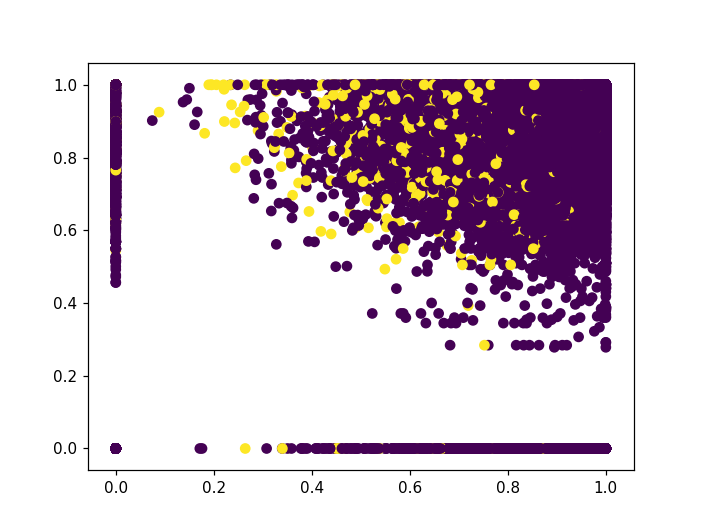

In [85]:
plt.scatter(plot_df.NormW2vDistance, plot_df.NormTagNerDistance, c = plot_df.Class)
plt.show()

##### Classification ###### 

In [175]:
plot_df.head()

,DataSetno,Parano,Qnno,Sentno,NormW2vDistance,NormTagDistance,NormTagNerDistance,w2v_mapping,Tag_mapping,TagNer_mapping,Class
0,0,0,0,0,0.912598,1.000000,1.000000,0,0,0,0
1,0,0,0,1,0.905303,0.895863,0.894446,0,0,0,0
2,0,0,0,2,1.000000,0.868555,0.923571,0,0,0,0
3,0,0,0,3,0.940852,0.920727,0.951739,0,0,0,0
4,0,0,0,4,0.950717,0.810323,0.800227,0,0,0,0


In [245]:
class_df = plot_df[['Class']]
#class_df
feature_df = plot_df[['NormW2vDistance','NormTagDistance','NormTagNerDistance']] 


In [246]:
X_test

,NormW2vDistance,NormTagDistance,NormTagNerDistance
2,1.000000,0.868555,0.923571
8,0.910033,1.000000,1.000000
4,0.950717,0.810323,0.800227


In [223]:
features = feature_df.columns 

In [247]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(feature_df, class_df, random_state=0)  

In [234]:
targets = ['good','bad'] 
features = ['NormW2vDistance','NormTagDistance','NormTagNerDistance']

In [238]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,Y_train)   

In [239]:

import pydotplus
from IPython.display import Image  


In [241]:
import pydotplus
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,
                        class_names= targets,  
      
                         filled=True, rounded=True,  
                         special_characters=True)  


In [243]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

In [248]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix

lr = LogisticRegression()
lr.fit(X_train,Y_train) 


/home/anjana/nltk/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

<IPython.core.display.Javascript object>


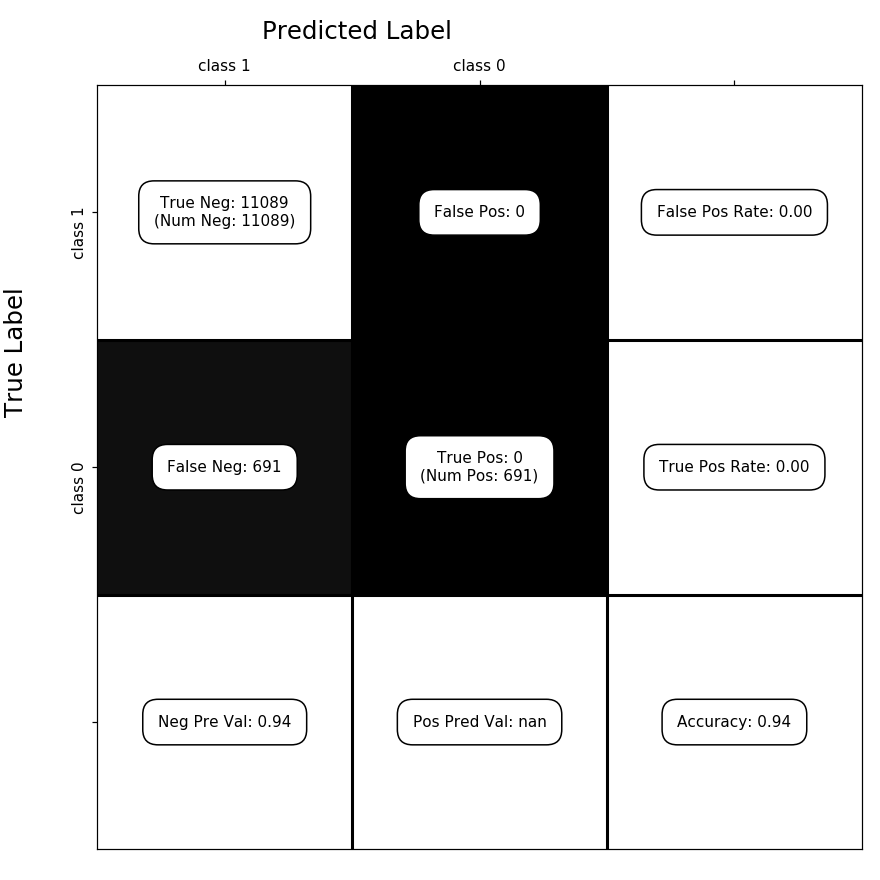

/home/anjana/nltk/lib/python3.5/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide


In [250]:
C = confusion_matrix(Y_test,lr.predict(X_test))
show_confusion_matrix(C, ['class 1', 'class 0'])


In [261]:
df

,DataSetno,Parano,Qnno,Sentno,ActualSent,TagPred_Sent,TagNerpred_Sent,I_Weipred_Sent,II_Weipred_Sent,III_Weipred_Sent,w2v_mapping,Tag_mapping,TagNer_mapping,I_Wei_mapping,II_Wei_mapping,III_Wei_mapping
5,0,0,0,5,6,4,4,4.0,5.0,5.0,0,0,0,0,0,0
10,0,0,1,3,3,4,4,4.0,3.0,3.0,1,0,0,0,1,1
17,0,0,2,3,4,6,4,3.0,3.0,3.0,0,0,1,0,0,0
24,0,0,3,3,5,4,4,4.0,4.0,5.0,0,0,0,0,0,1
31,0,0,4,3,2,4,4,4.0,3.0,3.0,0,0,0,0,0,0
2,0,1,0,2,3,10,5,10.0,10.0,2.0,0,0,0,0,0,0
20,0,1,1,9,4,10,5,10.0,3.0,0.0,0,0,0,0,0,0
22,0,1,2,0,6,0,5,0.0,0.0,0.0,0,0,0,0,0,0
33,0,1,3,0,2,10,5,10.0,0.0,0.0,0,0,0,0,0,0
51,0,1,4,7,8,0,5,0.0,0.0,7.0,0,0,0,0,0,0


In [260]:
print("W2V accuracy , " ":" ,df["w2v_mapping"].mean()) 
print("Tag accuracy , " ":" ,df["Tag_mapping"].mean()) 
print("Tag with NER accuracy , " ":" ,df["TagNer_mapping"].mean()) 

print()

print("accuracy for weight = 0.2, " ":" ,df["I_Wei_mapping"].mean()) 
print("accuracy for weight = 0.5, " ":" ,df["II_Wei_mapping"].mean()) 
print("accuracy for weight = 0.8, " ":" ,df["III_Wei_mapping"].mean()) 


W2V accuracy , : 0.0798141891892
Tag accuracy , : 0.173247466216
Tag with NER accuracy , : 0.163429054054

accuracy for weight = 0.2, : 0.160578547297
accuracy for weight = 0.5, : 0.136929898649
accuracy for weight = 0.8, : 0.111380912162


In [ ]:
cols = ['w2v_mapping','Tag_mapping']
plot_df[cols] = plot_df[cols].applymap(np.int64)
plot_df

In [118]:
cols = ['Rank_x','Rank_y']

w2v_tag_df = pd.concat(w2v_tag_tagner_list)
w2v_tag_df[cols]= w2v_tag_df[cols].applymap(np.int64)
w2v_tag_df

,DataSetno,Parano,Qnno,Sentno,w2vDistance,NormW2vDistance,Rank_x,TagDistance,NormTagDistance,Rank_y,TagNerDistance,NormTagNerDistance,Rank,I_Weidist,II_Weidist,III_Weidist
0,0,0,0,0,2.652292,0.912598,3,0.473181,1.000000,7,0.429590,1.000000,7.0,0.982520,0.956299,0.930078
1,0,0,0,1,2.631091,0.905303,2,0.423906,0.895863,3,0.384245,0.894446,3.0,0.897751,0.900583,0.903415
2,0,0,0,2,2.906310,1.000000,7,0.410984,0.868555,2,0.396756,0.923571,4.0,0.894844,0.934278,0.973711
3,0,0,0,3,2.734407,0.940852,5,0.435671,0.920727,5,0.408857,0.951739,6.0,0.924752,0.930790,0.936827
4,0,0,0,4,2.763077,0.950717,6,0.383430,0.810323,1,0.343769,0.800227,1.0,0.838402,0.880520,0.922638
5,0,0,0,5,2.120559,0.729640,1,0.424634,0.897402,4,0.366732,0.853680,2.0,0.863850,0.813521,0.763192
6,0,0,0,6,2.690732,0.925824,4,0.468626,0.990372,6,0.406164,0.945469,5.0,0.977463,0.958098,0.938734
7,0,0,1,0,2.678404,1.000000,7,0.348628,0.831396,3,0.367313,0.855229,4.0,0.865116,0.915698,0.966279
8,0,0,1,1,2.437435,0.910033,3,0.419329,1.000000,7,0.429491,1.000000,7.0,0.982007,0.955016,0.928026
9,0,0,1,2,2.435459,0.909295,2,0.406813,0.970154,6,0.419816,0.977475,6.0,0.957982,0.939725,0.921467


In [ ]:
w2v_tag_df

<IPython.core.display.Javascript object>


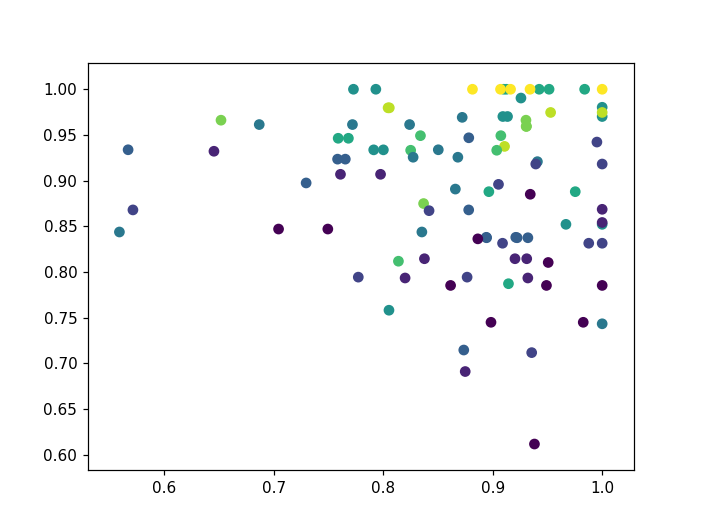

In [127]:
% matplotlib nbagg
plt.scatter(w2v_tag_df.head(100).NormW2vDistance, w2v_tag_df.head(100).NormTagDistance, c = w2v_tag_df.head(100).Rank_y) 
plt.show()

In [ ]:
% matplotlib nbagg
plt.scatter(w2v_tag_df.NormW2vDistance, w2v_tag_df.NormTagDistance, c = w2v_tag_df.Rank_x)
plt.show()

In [128]:
def classfun(list1,list2):
    classlist = [] 
    for i in range(len(list1)):
        if list1[i]==1 or list2[i]==1 :
            classlist.append(1) 
        else:
            classlist.append(0)  
    return classlist  

In [129]:
l1 = [1,0,1]
l2 = [0,0,1]
classfun(l1,l2)

[1, 0, 1]

In [112]:
w2vmapping_list = list(plot_df['w2v_mapping']) 
tagmapping_list = list(plot_df['Tag_mapping'])   

In [113]:
classfun(w2vmapping_list,tagmapping_list)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [64]:
w2v_tag_tagner_list[0] 

,DataSetno,Parano,Qnno,Sentno,w2vDistance,NormW2vDistance,Rank_x,TagDistance,NormTagDistance,Rank_y,TagNerDistance,NormTagNerDistance,Rank,I_Weidist,II_Weidist,III_Weidist
0,0,0,0,0,2.652292,0.912598,3.0,0.315948,0.624455,1.0,0.338630,0.792562,3.0,0.682084,0.768527,0.854969
1,0,0,0,1,2.631091,0.905303,2.0,0.505957,1.000000,7.0,0.412790,0.966133,6.0,0.981061,0.952651,0.924242
2,0,0,0,2,2.906310,1.000000,7.0,0.391347,0.773478,2.0,0.367266,0.859584,4.0,0.818782,0.886739,0.954696
3,0,0,0,3,2.734407,0.940852,5.0,0.505192,0.998488,6.0,0.427260,1.000000,7.0,0.986961,0.969670,0.952379
4,0,0,0,4,2.763077,0.950717,6.0,0.404977,0.800417,4.0,0.311809,0.729788,1.0,0.830477,0.875567,0.920657
5,0,0,0,5,2.120559,0.729640,1.0,0.397229,0.785103,3.0,0.316880,0.741656,2.0,0.774011,0.757372,0.740732
6,0,0,0,6,2.690732,0.925824,4.0,0.461093,0.911328,5.0,0.367926,0.861128,5.0,0.914227,0.918576,0.922925
7,0,0,1,0,2.678404,1.000000,7.0,0.419137,0.894018,4.0,0.390225,0.940342,5.0,0.915214,0.947009,0.978804
8,0,0,1,1,2.437435,0.910033,3.0,0.416904,0.889257,3.0,0.390927,0.942035,6.0,0.893412,0.899645,0.905878
9,0,0,1,2,2.435459,0.909295,2.0,0.406556,0.867185,2.0,0.378748,0.912687,4.0,0.875607,0.888240,0.900873


In [65]:
mapping_list[0] 

,DataSetno,Parano,Qnno,Sentno,ActualSent,TagPred_Sent,TagNerpred_Sent,I_Weipred_Sent,II_Weipred_Sent,III_Weipred_Sent,w2v_mapping,Tag_mapping,TagNer_mapping,I_Wei_mapping,II_Wei_mapping,III_Wei_mapping
5,0,0,0,5,6,0,4,0,5,5,0,0,0,0,0,0
10,0,0,1,3,3,6,6,6,3,3,1,0,0,0,1,1
17,0,0,2,3,4,0,0,0,3,3,0,0,0,0,0,0
24,0,0,3,3,5,6,6,6,6,3,0,0,0,0,0,0
31,0,0,4,3,2,6,6,6,3,3,0,0,0,0,0,0


In [66]:
list(mapping_list[0]['ActualSent'].index)

[5, 10, 17, 24, 31]

In [103]:
#list(w2v_tag_tagner_list[0].index)

In [67]:
w2v_tag_tagner_list[0].index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34],
           dtype='int64')

In [67]:
def common(list1,list2):
    l = [] 
    for element in list2:
        if element in list1:
            l.append(1)
        else:
            l.append(0)
    return l 
        

In [69]:
l1 = common(list(mapping_list[0]['ActualSent'].index) , list(w2v_tag_tagner_list[0].index))

In [98]:
pd.concat([w2v_tag_tagner_list[0]['Sentno'],mapping_list[0]['ActualSent']],axis =1)

,Sentno,ActualSent
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN
5,5,6.0
6,6,NaN
7,0,NaN
8,1,NaN
9,2,NaN


In [70]:
df = w2v_tag_tagner_list[0][['DataSetno','Parano','Qnno','Sentno','NormW2vDistance','NormTagDistance','NormTagNerDistance']] 
df['label'] = l1

/home/anjana/nltk/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [68]:
final_plot_df = [] 
for i in range(len(w2v_tag_tagner_list)):  
    df = w2v_tag_tagner_list[i][['DataSetno','Parano','Qnno','Sentno','NormW2vDistance','NormTagDistance','NormTagNerDistance']]
    df['label'] = common(list(mapping_list[i]['ActualSent'].index) , list(w2v_tag_tagner_list[i].index))
    final_plot_df.append(df) 
    print(i)



/home/anjana/nltk/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


In [69]:
len(w2v_tag_tagner_list)

2694

In [70]:
df = pd.concat(final_plot_df)

In [151]:
df  

,DataSetno,Parano,Qnno,Sentno,NormW2vDistance,NormTagDistance,NormTagNerDistance,label
0,0,0,0,0,0.912598,0.927707,1.000000,0
1,0,0,0,1,0.905303,0.852660,0.789088,0
2,0,0,0,2,1.000000,0.966021,0.887174,0
3,0,0,0,3,0.940852,0.912227,0.894073,0
4,0,0,0,4,0.950717,0.849783,0.786246,0
5,0,0,0,5,0.729640,0.910616,0.784717,1
6,0,0,0,6,0.925824,1.000000,0.814944,0
7,0,0,1,0,1.000000,1.000000,1.000000,0
8,0,0,1,1,0.910033,0.749474,0.778497,0
9,0,0,1,2,0.909295,0.906971,0.878580,0


In [130]:
df.to_csv("50finalplotdf",header = True, index = True)

In [137]:
class_zero = df[df['label']==0] 
class_zero

,DataSetno,Parano,Qnno,Sentno,NormW2vDistance,NormTagDistance,NormTagNerDistance,label
0,0,0,0,0,0.912598,0.927707,1.000000,0
1,0,0,0,1,0.905303,0.852660,0.789088,0
2,0,0,0,2,1.000000,0.966021,0.887174,0
3,0,0,0,3,0.940852,0.912227,0.894073,0
4,0,0,0,4,0.950717,0.849783,0.786246,0
6,0,0,0,6,0.925824,1.000000,0.814944,0
7,0,0,1,0,1.000000,1.000000,1.000000,0
8,0,0,1,1,0.910033,0.749474,0.778497,0
9,0,0,1,2,0.909295,0.906971,0.878580,0
11,0,0,1,4,0.949111,0.841563,0.682197,0


In [147]:
%matplotlib nbagg 

<IPython.core.display.Javascript object>


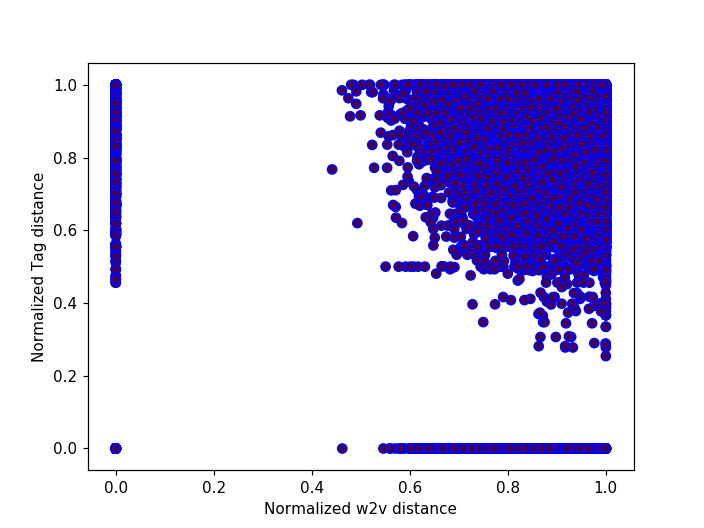

In [148]:
plt.scatter(class_zero.NormW2vDistance, class_zero.NormTagDistance, c = class_zero.label, edgecolors='blue')
plt.show()
plt.xlabel('Normalized w2v distance', fontsize=10)
plt.ylabel('Normalized Tag distance', fontsize=10) 

In [140]:
class_one = df[df['label']==1] 
class_one

,DataSetno,Parano,Qnno,Sentno,NormW2vDistance,NormTagDistance,NormTagNerDistance,label
5,0,0,0,5,0.729640,0.910616,0.784717,1
10,0,0,1,3,0.771934,0.785890,0.840653,1
17,0,0,2,3,0.645446,0.894377,0.894662,1
24,0,0,3,3,0.824119,0.785890,0.840653,1
31,0,0,4,3,0.686815,0.785890,0.840653,1
2,0,1,0,2,0.805287,0.873641,0.813335,1
20,0,1,1,9,0.805598,0.986175,0.883034,1
22,0,1,2,0,0.704452,0.998022,0.869759,1
33,0,1,3,0,0.559121,0.888198,0.805972,1
51,0,1,4,7,0.651888,0.861357,0.932661,1


In [149]:
%matplotlib nbagg 

<IPython.core.display.Javascript object>


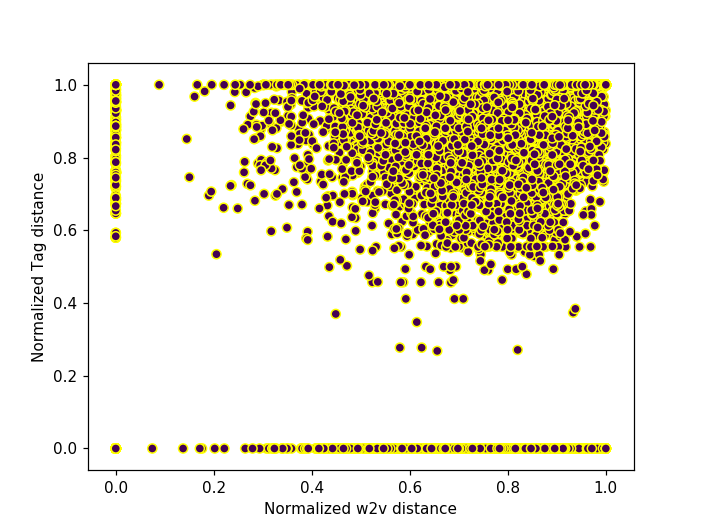

In [150]:
plt.scatter(class_one.NormW2vDistance, class_one.NormTagDistance, c = class_one.label,edgecolors='yellow')
plt.show()
plt.xlabel('Normalized w2v distance', fontsize=10)
plt.ylabel('Normalized Tag distance', fontsize=10) 

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
%matplotlib nbagg 

<IPython.core.display.Javascript object>


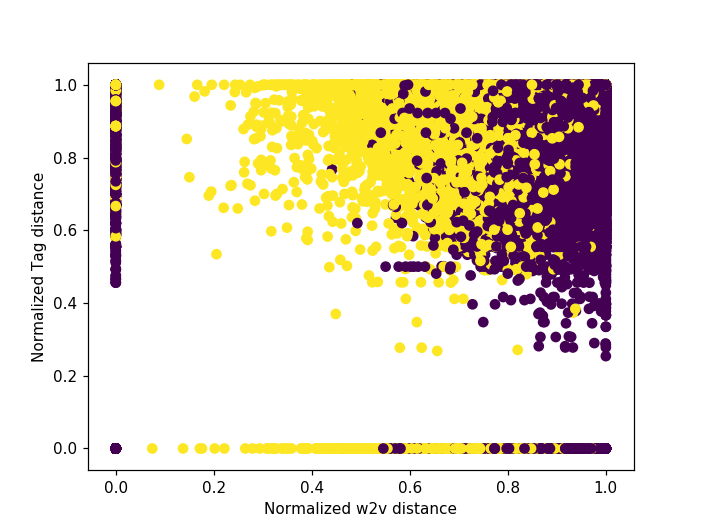

In [153]:
plt.scatter(df.NormW2vDistance, df.NormTagDistance, c = df.label)
plt.show()
plt.xlabel('Normalized w2v distance', fontsize=10)
plt.ylabel('Normalized Tag distance', fontsize=10) 

<IPython.core.display.Javascript object>


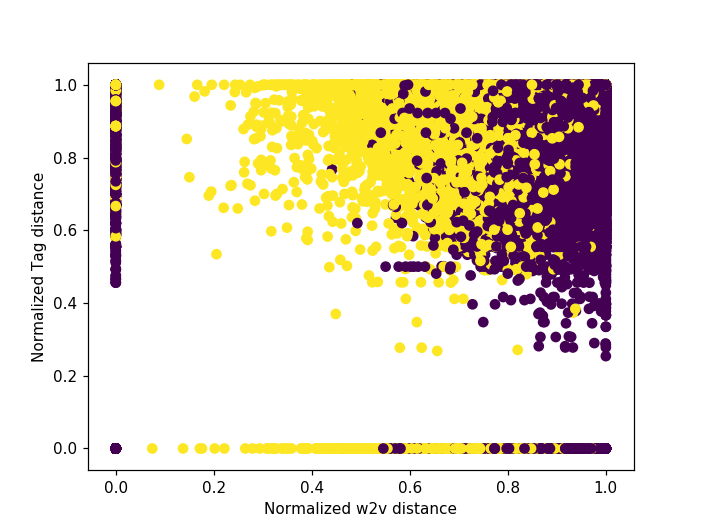

In [73]:
plt.scatter(df.NormW2vDistance, df.NormTagDistance, c = df.label)
plt.show()
plt.xlabel('Normalized w2v distance', fontsize=10)
plt.ylabel('Normalized Tag distance', fontsize=10) 

In [77]:
df.head(3) 

,DataSetno,Parano,Qnno,Sentno,NormW2vDistance,NormTagDistance,NormTagNerDistance,label
0,0,0,0,0,0.912598,0.927707,1.000000,0
1,0,0,0,1,0.905303,0.852660,0.789088,0
2,0,0,0,2,1.000000,0.966021,0.887174,0


In [79]:
features = list(df[['NormW2vDistance','NormTagDistance','NormTagNerDistance']]) 


In [81]:
features 

['NormW2vDistance', 'NormTagDistance', 'NormTagNerDistance']

In [83]:
#df[features]            

In [85]:
from sklearn.model_selection import train_test_split


In [86]:
y = df["label"] 
X = df[features] 

# Split the data into a training set and a test set
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0)  

In [93]:
print(len(X_train))
print(len(X_test))

45096
15033


In [89]:
targets = ['0','1']

In [110]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train.head(50),Y_train.head(50))   

In [111]:
import pydotplus
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,
                        class_names= targets,  
      
                         filled=True, rounded=True,  
                         special_characters=True)  


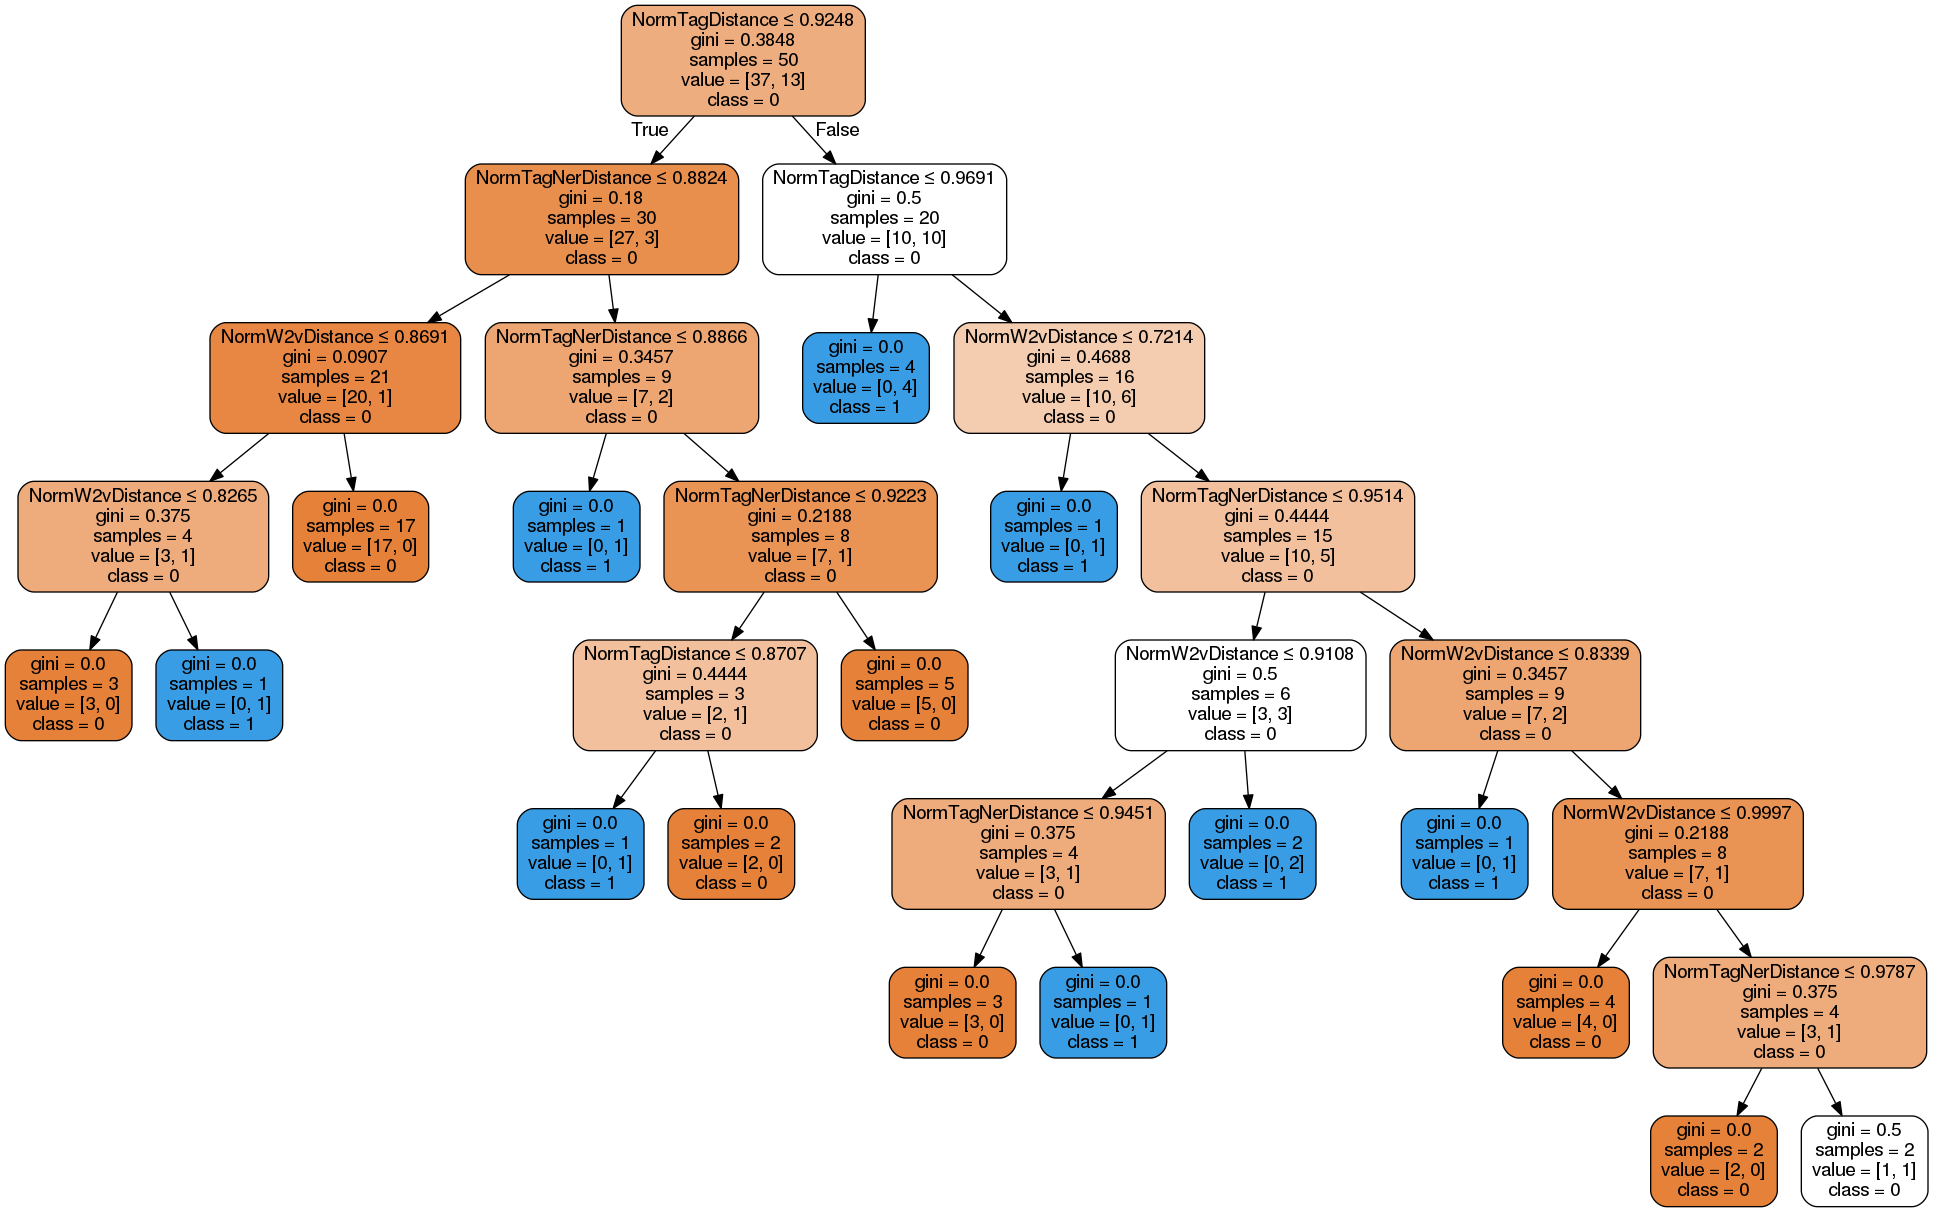

In [112]:
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

#####  Logistic Regression #####

In [113]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix

lr = LogisticRegression()
lr.fit(X_train,Y_train) 


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [114]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

In [120]:
%matplotlib inline 

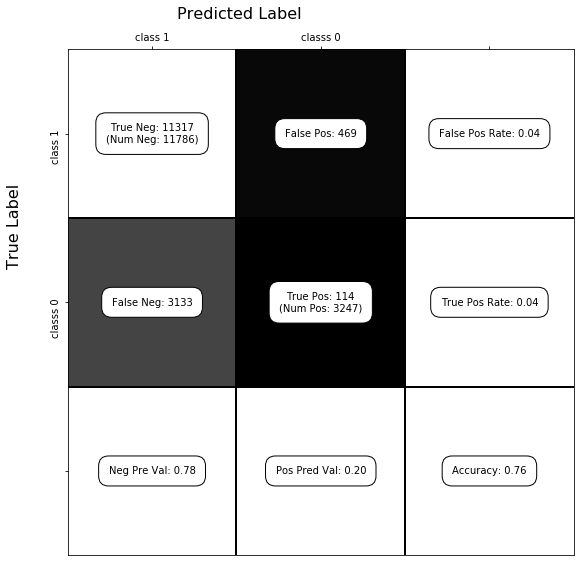

In [122]:
C = confusion_matrix(Y_test,lr.predict(X_test))
show_confusion_matrix(C, ['class 1', 'classs 0'])


##### Cost function ##### 

In [123]:
from pyemd import emd_with_flow


In [124]:
emd_with_flow(first_histogram, second_histogram, distance_matrix)


NameError: name 'first_histogram' is not defined

##### SVM #####

In [28]:
def fun1(qnlist):
    punc=set(",./;'?&-")

    common_list = []
    for qns in qnlist:
        for i in range(len(qns)):
            if (qns[i] == 'how'):
                common_list.append('how i') 

        list1 = (qns.lower().split())
        
        
        list2 = list(set(list1).intersection(qtntype_list)) 
        for j in list2:
            strp =''.join(c for c in j if not c in punc)
        common_list.append(strp) 
        if list2 == []:
            common_list.append('others') 
    
    
    
            
            
            
            
    
        
        
    return common_list 

In [29]:
l1 =['what is ur name?','when it ?','how r ']
l1

['what is ur name?', 'when it ?', 'how r ']

In [125]:
def replace_all(repls, str):
   # return re.sub('|'.join(repls.keys()), lambda k: repls[k.group(0)], str)                                    
   return re.sub('|'.join(re.escape(key) for key in repls.keys()),
                 lambda k: repls[k.group(0)], str)

In [127]:
import re
text =  "i like apples, but pears scare me"
text =  replace_all({"apple": "pear", "pear": "apple"}, text)
text

'i like pears, but apples scare me'

In [30]:
qtntype_list = ['why','how', 'what', 'when','which', 'who','whom', 'where','whose']
qtntype_list

['why', 'how', 'what', 'when', 'which', 'who', 'whom', 'where', 'whose']

In [31]:
fun1(l1) 

['what', 'when', 'how i']

In [18]:
l1  

['what is ur name?', 'when it ?', 'how r ']

In [14]:
qn_type_list =[] 
for i in range(len(l1)):
    split_list = l1[i].split()
    for j in range(len(split_list)):
        if (split_list[j]=='how'):
            how_qn_ext = [split_list[j],split_list[j+1]]
            how_qn_ext = " ".join(how_qn_ext)
            print(how_qn_ext) 
            


how r


In [82]:
l1 =['when','will','u','?']
l2 =['what','when']          


In [83]:
punc=set(",./;'?&-")
punc

{'&', "'", ',', '-', '.', '/', ';', '?'}

In [84]:
def qntypext(qn,qntype_list):
    comm =[] 
    for i in range(len(l1)):  
        if (l1[i]=='how'):
            how_qn_ext = [l1[i],l1[i+1]] 
            how_qn_ext = " ".join(how_qn_ext)
            comm.append(how_qn_ext)
    if 'how' not in l1:
        list2 = list(set(l1).intersection(l2)) 
        for j in list2:
            strp =''.join(c for c in j if not c in punc)
            comm.append(strp) 
    return comm
    
   # comm.append() 


In [85]:
qntypext(l1,l2)

['when']

In [76]:
comm

['how will']

In [89]:
l1 =['whe','will','u','?']
l2 =['what','when']          


In [94]:
def comm_list(l1,l2):  
    comm =[] 
    for i in range(len(l1)):  
        if (l1[i]=='how'):
            how_qn_ext = [l1[i],l1[i+1]] 
            how_qn_ext = " ".join(how_qn_ext)
            comm.append(how_qn_ext)
    if 'how' not in l1:
        list2 = list(set(l1).intersection(l2)) 
        for j in list2:
                strp =''.join(c for c in j if not c in punc)
                comm.append(strp) 
        if (list2 == []):
            comm.append('others')
    return comm
    

In [95]:
comm_list(l1,l2)

['others']

In [97]:
l1 = ['is','it','?']
l1

['is', 'it', '?']

In [98]:
l2

['what', 'when']

In [99]:
comm_list(l1,l2)

['others']

In [100]:
l1 = ["what is f.a. hayek's profession?",
 'according to hayek, with the rule of law in place what will help people make more wise investments?',
 'according to hayek, limited governemnt power through the rule of law does not do what to people?',
 'according to hayek, people are free to do what within the rule of law?'] 

In [103]:
l1[0].split()

['what', 'is', 'f.a.', "hayek's", 'profession?']

In [102]:
l2 = ['how', 'what', 'when', 'why', 'which', 'who', 'whom', 'where']
l2

['how', 'what', 'when', 'why', 'which', 'who', 'whom', 'where']

In [111]:
ls = [] 
for i in range(len(l1)):
    tokenl1 = l1[i].split()
    ls.append(comm_list(tokenl1,l2)) 

In [112]:
ls

['what', 'what', 'what', 'what']

In [113]:
def comm_list(l1,l2):  
    #comm =[] 
    for i in range(len(l1)):  
        if (l1[i]=='how'):
            how_qn_ext = [l1[i],l1[i+1]] 
            how_qn_ext = " ".join(how_qn_ext)
            qntype = how_qn_ext
    if 'how' not in l1:
        list2 = list(set(l1).intersection(l2)) 
        for j in list2:
                strp =''.join(c for c in j if not c in punc)
                qntype = strp  
        if (list2 == []):
            qntype = 'others' 
    return qntype
    

In [119]:
def qn_type(l1,l2):
    ls = []
    for i in range(len(l1)):
        tokenl1 = l1[i].split()
        ls.append(comm_list(tokenl1,l2)) 
    return ls

        

In [115]:
l1 = ['what is your name ?','when it will happen ?','how old r u']
l1

['what is your name ?', 'when it will happen ?', 'how old r u']

In [116]:
l1[0]

'what is your name ?'

In [117]:
l2

['how', 'what', 'when', 'why', 'which', 'who', 'whom', 'where']

In [120]:
qn_type(l1,l2)

['what', 'when', 'how old']

In [121]:
str = "What $noun$ is $verb$?"
print(str.replace("$noun$", "the heck"))


What the heck is $verb$?
